# TheoTown Game Reviews: Comparative Analysis (ID vs US)

**Correction Note**: Previous runs may have produced identical data for ID and US because forcing `lang='en'` for Indonesia often returns the global/default English review set if local English reviews are scarce. 

**New Strategy**: 
1.  **Indonesia (ID)**: Scrape with `lang='id'` to capture authentic local reviews.
2.  **United States (US)**: Scrape with `lang='en'`.
3.  **Process**: Use **Dual Sentiment Analysis** (Indonesian dictionary for ID, English dictionary for US).
4.  **Visualize**: Compare satisfaction levels and common topics across these distinct user bases.

### 1. Imports
- `pandas`: Data manipulation.
- `matplotlib` / `seaborn`: Visualization.
- `google_play_scraper`: Data collection.
- `re` / `wordcloud`: Text processing.
- `TextBlob` (optional): Fallback for English sentiment if needed, but we used a custom lexicon here for speed.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google_play_scraper import app, Sort, reviews
from wordcloud import WordCloud, STOPWORDS
import re

%matplotlib inline
print("Libraries successfully imported.")

Libraries successfully imported.


### 2. Scraping Function
Fetches reviews with region-specific language settings.
- ID -> `lang='id'`
- US -> `lang='en'`

In [36]:
def scrape_reviews(app_id, region, count=500):
    # Determine appropriate language for the region to ensure unique, local data
    language = 'id' if region == 'id' else 'en'
    
    print(f"...Scraping {region.upper()} (using lang='{language}')...")
    try:
        result, continuation_token = reviews(
            app_id,
            lang=language, 
            country=region, 
            sort=Sort.NEWEST,
            count=count
        )
        df = pd.DataFrame(result)
        df['region'] = region.upper()
        df['scraped_lang'] = language
        return df
    except Exception as e:
        print(f"Error scraping {region}: {e}")
        return pd.DataFrame()

print("Scraping function defined.")

Scraping function defined.


### 3. Dual Sentiment Analyzers
We need two dictionaries to correctly judge sentiment in two different languages.

In [37]:
def analyze_sentiment_id(text):
    # Indonesian Lexicon
    if not isinstance(text, str): return 0, 'Neutral'
    text = text.lower()
    pos_words = ['bagus', 'keren', 'mantap', 'suka', 'seru', 'asik', 'best', 'good', 'puas', 'enak']
    neg_words = ['jelek', 'buruk', 'benci', 'lag', 'bug', 'macet', 'susah', 'kecewa', 'nyesel', 'parah']
    
    score = sum([1 for w in pos_words if w in text]) - sum([1 for w in neg_words if w in text])
    if score > 0: return score, 'Positive'
    elif score < 0: return score, 'Negative'
    return score, 'Neutral'

def analyze_sentiment_en(text):
    # English Lexicon
    if not isinstance(text, str): return 0, 'Neutral'
    text = text.lower()
    pos_words = ['good', 'great', 'awesome', 'excellent', 'amazing', 'love', 'best', 'nice', 'fun', 'perfect']
    neg_words = ['bad', 'worst', 'terrible', 'awful', 'hate', 'boring', 'lag', 'bug', 'crash', 'slow']
    
    score = sum([1 for w in pos_words if w in text]) - sum([1 for w in neg_words if w in text])
    if score > 0: return score, 'Positive'
    elif score < 0: return score, 'Negative'
    return score, 'Neutral'

def get_sentiment(row):
    # Dispatcher function
    if row['scraped_lang'] == 'id':
        return analyze_sentiment_id(row['content'])
    else:
        return analyze_sentiment_en(row['content'])

print("Sentiment analyzers defined.")

Sentiment analyzers defined.


### 4. Main Execution
Runs the scraping and processing pipeline.

In [38]:
APP_ID = 'info.flowersoft.theotown.theotown'
REGIONS = ['id', 'us']
SAFE_COUNT = 2000 # Keeping safe limit for demo

dfs = []
for region in REGIONS:
    dfs.append(scrape_reviews(APP_ID, region, count=SAFE_COUNT))

df = pd.concat(dfs, ignore_index=True)

if not df.empty:
    print(f"\nTotal scraped: {len(df)}")
    # Remove duplicates just in case
    df.drop_duplicates(subset=['reviewId'], inplace=True)
    print(f"After deduplication: {len(df)}")
    
    # Apply Sentiment Analysis
    print("Analyzing sentiment...")
    df[['score_val', 'sentiment']] = df.apply(get_sentiment, axis=1).apply(pd.Series)
    
    print("Preview of data:")
    print(df[['region', 'content', 'sentiment']].head())
    
    print("\nSentiment Counts per Region:")
    print(df.groupby('region')['sentiment'].value_counts())
else:
    print("No data found.")

...Scraping ID (using lang='id')...
...Scraping US (using lang='en')...

Total scraped: 4000
After deduplication: 4000
Analyzing sentiment...
Preview of data:
  region                                            content sentiment
0     ID                                          good game  Positive
1     ID                               fomo doang sih 😁 😂 😂   Neutral
2     ID                                               good  Positive
3     ID     game taaaaaiiii buriqq banget bikin sakit mata   Neutral
4     ID  gemnya baguss ,seru. min tolong tambah fitur u...  Positive

Sentiment Counts per Region:
region  sentiment
ID      Positive     1341
        Neutral       599
        Negative       60
US      Neutral      1048
        Positive      913
        Negative       39
Name: count, dtype: int64


## Visualizations

Generating Rating Chart...


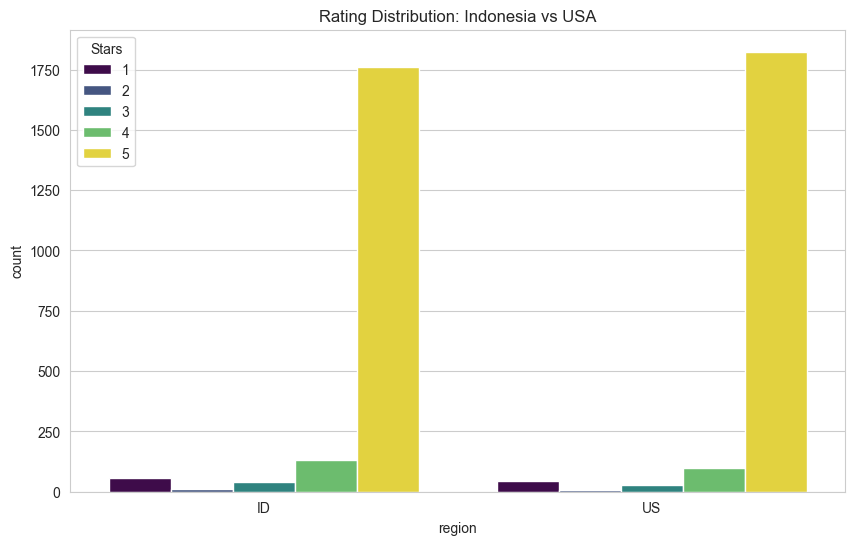

Rating Chart displayed.


In [39]:
print("Generating Rating Chart...")
if not df.empty:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='region', hue='score', data=df, palette='viridis')
    plt.title('Rating Distribution: Indonesia vs USA')
    plt.legend(title='Stars')
    plt.show()
    print("Rating Chart displayed.")

Generating Sentiment Pie Charts...


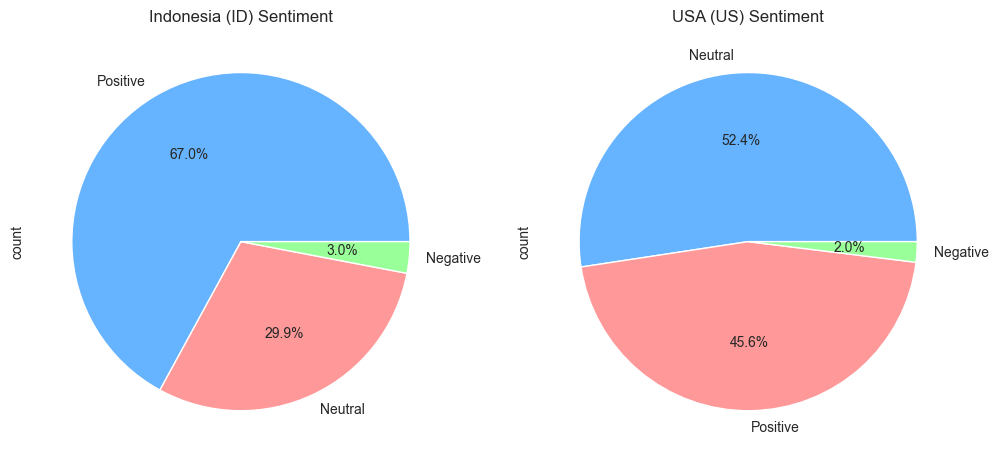

Pie Charts displayed.


In [40]:
print("Generating Sentiment Pie Charts...")
if not df.empty:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    df[df['region']=='ID']['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#ff9999','#99ff99'])
    plt.title('Indonesia (ID) Sentiment')

    plt.subplot(1, 2, 2)
    df[df['region']=='US']['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#ff9999','#99ff99'])
    plt.title('USA (US) Sentiment')
    
    plt.show()
    print("Pie Charts displayed.")

Generating Word Clouds...


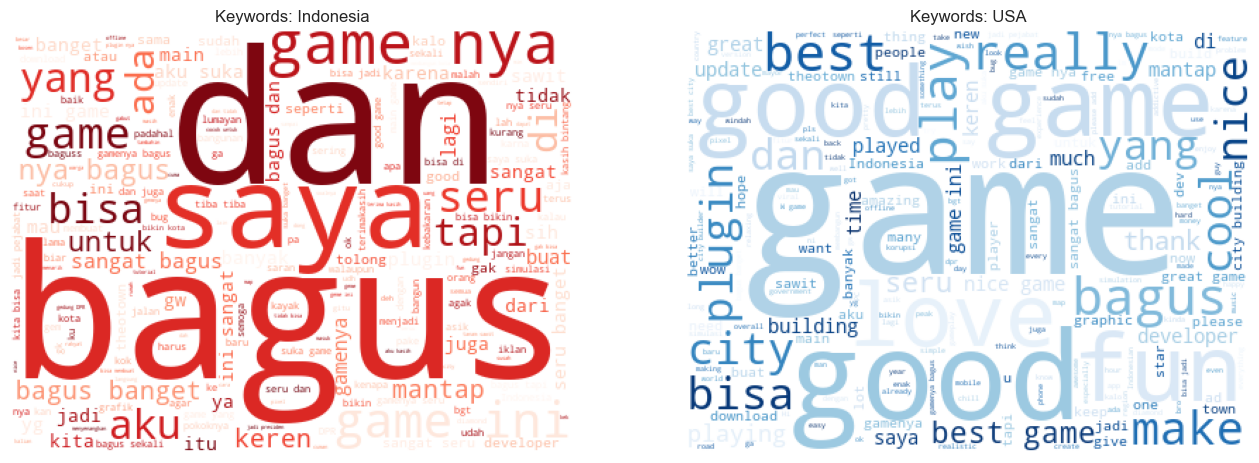

Word Clouds displayed.


In [41]:
print("Generating Word Clouds...")
if not df.empty:
    plt.figure(figsize=(16, 8))
    
    # Indonesia WordCloud
    plt.subplot(1, 2, 1)
    text_id = " ".join(str(t) for t in df[df['region']=='ID']['content'])
    if text_id.strip():
        wc_id = WordCloud(width=400, height=300, background_color='white', colormap='Reds').generate(text_id)
        plt.imshow(wc_id)
        plt.axis('off')
        plt.title('Keywords: Indonesia')
    
    # USA WordCloud
    plt.subplot(1, 2, 2)
    text_us = " ".join(str(t) for t in df[df['region']=='US']['content'])
    if text_us.strip():
        wc_us = WordCloud(width=400, height=300, background_color='white', colormap='Blues').generate(text_us)
        plt.imshow(wc_us)
        plt.axis('off')
        plt.title('Keywords: USA')

    plt.show()
    print("Word Clouds displayed.")